In [1]:
# CELL 1: INSTALASI LIBRARY

!pip install pandas torch transformers seaborn matplotlib tqdm openpyxl scikit-learn ipywidgets

In [53]:
# CELL 2: IMPORT & KONFIGURASI

import os
import glob
import re
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm.auto import tqdm  # Pakai tqdm khusus notebook biar loading bar-nya cantik

# --- PENGATURAN TAMPILAN GRAFIK ---
sns.set_style("whitegrid") # Biar background grafik ada garis-garis grid (lebih rapi)
%matplotlib inline 
# ^ Perintah "Magic" agar grafik muncul langsung di bawah cell ini (bukan pop-up)

# --- KONFIGURASI PROYEK ---
# Sesuaikan dengan nama folder di GitHub kamu
NAMA_FOLDER_DATA = 'DataSampel/Clean' 

# Label Kategori (Kamu bisa ubah/tambah list ini sesuai kebutuhan manajemen)
# AI akan menggunakan "Zero-Shot Learning" untuk mencocokkan review ke kategori ini.
CANDIDATE_LABELS = [
    "Kualitas Makanan & Restoran",      
    "Kebersihan & Kenyamanan Kamar",    
    "Pelayanan Staf & Keramahan",       
    "Fasilitas Hotel (Kolam/Gym/Spa)",  
    "Lokasi & Akses Strategis",         
    "Infrastruktur (AC/WiFi/Parkir/Air)", 
    "Harga & Value for Money"           
]

print("Konfigurasi selesai. Lanjut ke Cell berikutnya.")

Konfigurasi selesai. Lanjut ke Cell berikutnya.


In [54]:
def setup_models():
    print("MEMUAT AI MODEL")
    
    device = 0 if torch.cuda.is_available() else -1
    if device == 0:
        print(f"GPU Terdeteksi: {torch.cuda.get_device_name(0)}")
    else:
        print("Menggunakan CPU.")

    # --- KITA KEMBALI KE MODEL RINGAN ---
    # Model ini lebih kecil (400MB) jadi kemungkinan sukses download lebih besar
    model_sentiment = "w11wo/indonesian-roberta-base-sentiment-classifier"
    model_zeroshot = "MoritzLaurer/mDeBERTa-v3-base-mnli-xnli"

    try:
        print("Sedang memuat model... (Harap pastikan internet lancar)")
        clf_sentiment = pipeline("sentiment-analysis", model=model_sentiment, tokenizer=model_sentiment, device=device)
        clf_aspect = pipeline("zero-shot-classification", model=model_zeroshot, device=device)
        print("SUKSES! Model Siap.")
        return clf_sentiment, clf_aspect
    except Exception as e:
        print(f"Error Internet: {e}")
        return None, None

clf_sentiment, clf_aspect = setup_models()

MEMUAT AI MODEL
GPU Terdeteksi: NVIDIA GeForce RTX 3050 6GB Laptop GPU
Sedang memuat model... (Harap pastikan internet lancar)


Device set to use cuda:0
Device set to use cuda:0


SUKSES! Model Siap.


In [55]:
# CELL 4: DATA LOADING & CLEANING

def clean_text_safe(text):
    """Membersihkan teks tapi JANGAN hapus Emoji/Tanda Baca"""
    text = str(text)
    text = re.sub(r'<.*?>', ' ', text)  # Hapus tag HTML
    text = re.sub(r'http\S+', '', text) # Hapus Link/URL
    text = " ".join(text.split())       # Hapus spasi berlebih
    return text

def load_data(folder_name):
    print(f"Mencari data di folder: {folder_name}")
    
    current_dir = os.getcwd()
    target_path = os.path.join(current_dir, folder_name)
    
    # Jika tidak ketemu, naik satu folder (kalau notebook ada di src)
    if not os.path.exists(target_path):
        target_path = os.path.join(current_dir, "..", folder_name)
    
    if not os.path.exists(target_path):
        print(f"Gagal menemukan folder '{folder_name}'. Cek struktur foldermu.")
        return pd.DataFrame()

    # Ambil semua CSV dari subfolder BUMN dan KOMPETITOR
    files = glob.glob(os.path.join(target_path, "**", "*.csv"), recursive=True)
    all_dfs = []
    
    print(f"Ditemukan {len(files)} file CSV. Mulai membaca...")

    for file_path in files:
        try:
            path_parts = os.path.normpath(file_path).split(os.sep)

            # Ambil label dari struktur folder
            # DataSampel/Clean/BUMN/NamaFile.csv
            tipe_hotel = path_parts[-2]   # BUMN atau KOMPETITOR
            nama_hotel = os.path.basename(file_path).replace('.csv', '')

            df = pd.read_csv(file_path)

            # Normalisasi kolom review
            col_map = {}
            for col in df.columns:
                lower_col = col.lower()
                if ('review' in lower_col and 'text' in lower_col) or 'content' in lower_col:
                    col_map[col] = 'text_review'
            
            df = df.rename(columns=col_map)

            if 'text_review' in df.columns:
                df['Tipe'] = tipe_hotel
                df['Nama_Hotel'] = nama_hotel
                
                cols = ['text_review', 'Rating', 'Tipe', 'Nama_Hotel']
                valid_cols = [c for c in cols if c in df.columns]
                all_dfs.append(df[valid_cols])

        except Exception as e:
            print(f"Error baca file {file_path}: {e}")
            continue

    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        final_df = final_df.dropna(subset=['text_review']).drop_duplicates(subset=['text_review'])
        print(f"BERHASIL! Total Data Bersih: {len(final_df)} Review.")
        return final_df
    else:
        print("Data Kosong.")
        return pd.DataFrame()

In [56]:
# CELL 5: LOAD DATA SEKARANG

# Panggil fungsi load
df_hotel = load_data(NAMA_FOLDER_DATA)

# Tampilkan 5 data teratas sebagai sampel
if not df_hotel.empty:
    print("\nContoh 5 Data Pertama:")
    display(df_hotel.head()) # 'display' khusus untuk mempercantik tabel di Jupyter
else:
    print("Tidak ada data untuk ditampilkan.")

Mencari data di folder: DataSampel/Clean
Ditemukan 4 file CSV. Mulai membaca...
BERHASIL! Total Data Bersih: 1912 Review.

Contoh 5 Data Pertama:


,text_review,Rating,Tipe,Nama_Hotel
0,hotel bintang 3 harga bintang 4 tapi sangat ma...,5,BUMN,KHASMalioboroHotel_Clean
1,Saya menginap 1 malam hanya dengan rekan-rekan...,5,BUMN,KHASMalioboroHotel_Clean
2,hotelnya bagus pelayanan ramah suka karena dis...,4,BUMN,KHASMalioboroHotel_Clean
3,hotelnya over all bgus lokasi juga deket sekal...,3,BUMN,KHASMalioboroHotel_Clean
4,first time ke jogja inap di hotel khas untuk s...,5,BUMN,KHASMalioboroHotel_Clean


In [57]:
# CELL 6: MENJALANKAN ANALISIS 

def run_analysis_notebook(df):
    if df.empty:
        print("Data kosong, tidak bisa analisis.")
        return df

    print("Memulai Analisis Sentimen & Topik...")
    
    # 1. Bersihkan Teks Dulu
    df['clean_text'] = df['text_review'].apply(clean_text_safe)
    texts = df['clean_text'].astype(str).tolist()
    
    results_sentiment = []
    results_aspect = []
    
    # 2. Loop Analisis dengan Progress Bar
    for text in tqdm(texts, desc="Sedang Menganalisis"):
        # A. Sentimen (IndoBERT)
        try:
            # Potong teks max 512 karakter (batas kemampuan BERT)
            res = clf_sentiment(text[:512], truncation=True, max_length=512)[0]
            sentiment_label = res['label']
        except:
            sentiment_label = "neutral"
            
        # B. Aspek (Zero-Shot)
        try:
            res = clf_aspect(text[:512], CANDIDATE_LABELS, multi_label=False)
            best_aspect = res['labels'][0] # Ambil skor tertinggi
        except:
            best_aspect = "Lainnya"
            
        results_sentiment.append(sentiment_label)
        results_aspect.append(best_aspect)
        
    # 3. Masukkan Hasil ke Tabel
    df['AI_Sentiment'] = results_sentiment
    df['AI_Aspek'] = results_aspect
    
    return df

# --- JALANKAN ANALISIS ---

# Kalau mau proses SEMUA data (mungkin lama), pakai baris ini:
df_result = run_analysis_notebook(df_hotel)

# Simpan ke Excel biar aman
df_result.to_excel("Hasil_Analisis_Lengkap.xlsx", index=False)
print("Analisis Selesai! File Excel 'Hasil_Analisis_Lengkap.xlsx' sudah disimpan.")

# Lihat hasilnya
df_result[['text_review', 'AI_Sentiment', 'AI_Aspek']].head()

Memulai Analisis Sentimen & Topik...


Sedang Menganalisis:   0%|          | 0/1912 [00:00<?, ?it/s]

Analisis Selesai! File Excel 'Hasil_Analisis_Lengkap.xlsx' sudah disimpan.


,text_review,AI_Sentiment,AI_Aspek
0,hotel bintang 3 harga bintang 4 tapi sangat ma...,positive,Lokasi & Akses Strategis
1,Saya menginap 1 malam hanya dengan rekan-rekan...,positive,Pelayanan Staf & Keramahan
2,hotelnya bagus pelayanan ramah suka karena dis...,positive,Pelayanan Staf & Keramahan
3,hotelnya over all bgus lokasi juga deket sekal...,positive,Lokasi & Akses Strategis
4,first time ke jogja inap di hotel khas untuk s...,positive,Kebersihan & Kenyamanan Kamar


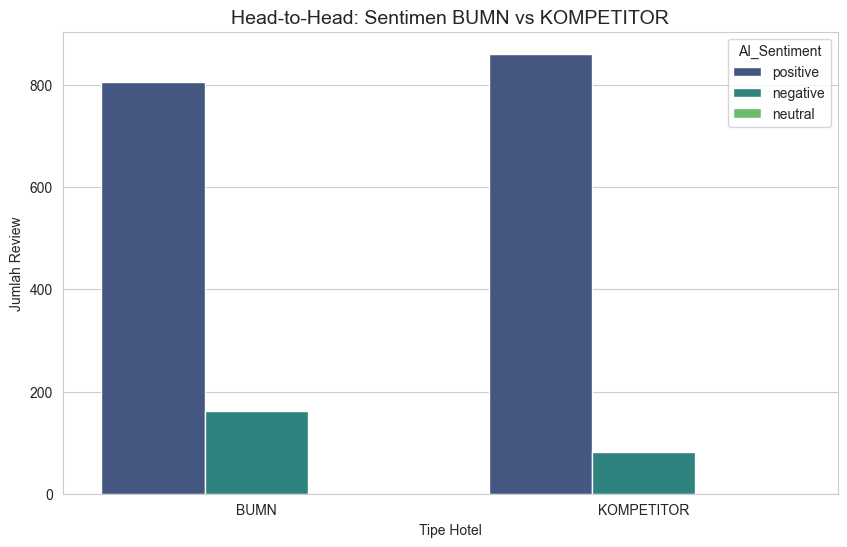

In [58]:
# CELL 7: GRAFIK 1 - PERBANDINGAN TIPE

plt.figure(figsize=(10, 6))

# Membuat Bar Chart
sns.countplot(data=df_result, x='Tipe', hue='AI_Sentiment', palette='viridis')

plt.title('Head-to-Head: Sentimen BUMN vs KOMPETITOR', fontsize=14)
plt.xlabel('Tipe Hotel')
plt.ylabel('Jumlah Review')
plt.show()

In [59]:
# CELL 8: GRAFIK 2 - PERBANDINGAN KELAS BINTANG

plt.figure(figsize=(10, 6))

try:
    # Urutkan agar grafik rapi (Bintang3 -> Bintang4 -> Bintang5)
    order_bintang = sorted(df_result['Kelas'].unique())
    
    sns.countplot(data=df_result, x='Kelas', hue='AI_Sentiment', order=order_bintang, palette='rocket')
    
    plt.title('Distribusi Sentimen Berdasarkan Kelas Bintang', fontsize=14)
    plt.xlabel('Kelas Hotel')
    plt.ylabel('Jumlah Review')
    plt.show()
except Exception as e:
    print(f"Gagal membuat grafik bintang: {e}")



Gagal membuat grafik bintang: 'Kelas'


<Figure size 1000x600 with 0 Axes>

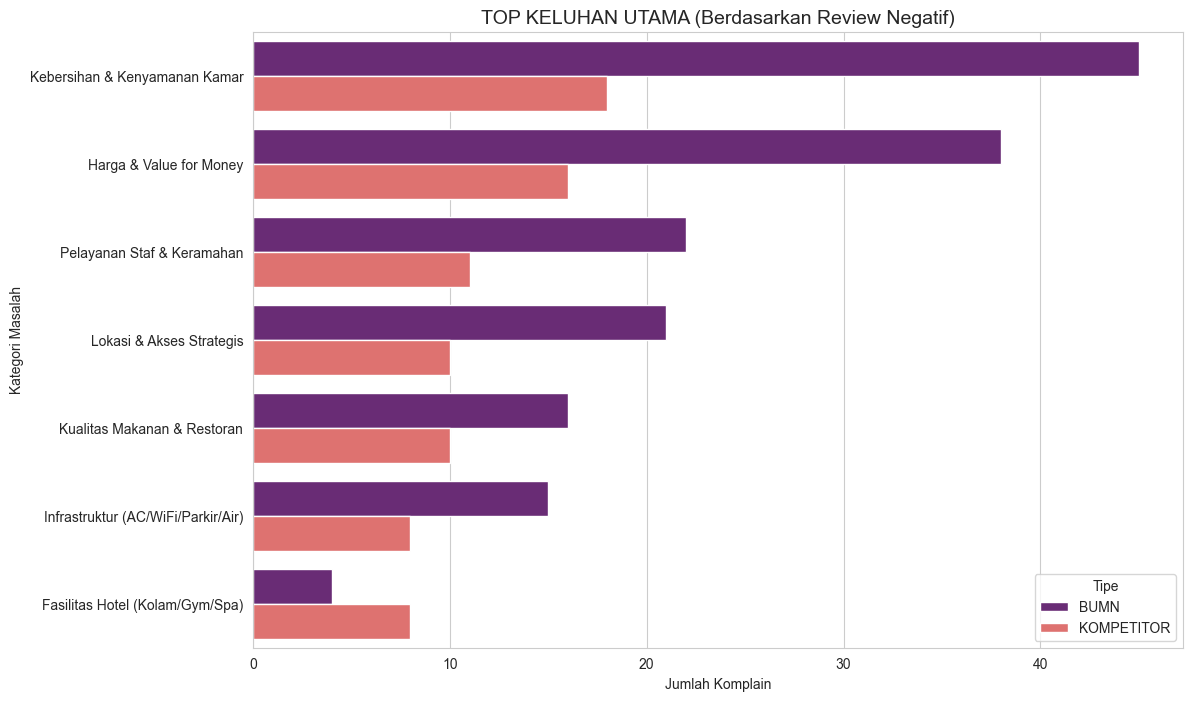

In [60]:
# CELL 9: GRAFIK 3 - PETA MASALAH (Review Negatif Saja)


# Filter: Ambil hanya yang sentimennya NEGATIVE
df_neg = df_result[df_result['AI_Sentiment'] == 'negative']

if not df_neg.empty:
    plt.figure(figsize=(12, 8))
    
    # Hitung aspek mana yang paling banyak dikeluhkan
    order_aspek = df_neg['AI_Aspek'].value_counts().index
    
    # Buat grafik horizontal
    sns.countplot(data=df_neg, y='AI_Aspek', hue='Tipe', order=order_aspek, palette='magma')
    
    plt.title('TOP KELUHAN UTAMA (Berdasarkan Review Negatif)', fontsize=14)
    plt.xlabel('Jumlah Komplain')
    plt.ylabel('Kategori Masalah')
    plt.show()
else:
    print("Wow! Tidak ada review negatif sama sekali.")